# Loop 82 Strategic Analysis

## Critical Situation Assessment

**82 experiments completed. Best LB: 0.0877. Target: 0.0347. Gap: 152.8%**

### Key Findings from Evaluator:
1. **GNN Mixture Bug**: The GNN only uses Solvent A's graph for mixtures, ignoring Solvent B entirely
2. **CV-LB Line**: All 12 valid submissions follow LB = 4.29 * CV + 0.053 (R² = 0.95)
3. **Intercept Problem**: Intercept (0.053) > Target (0.0347) - mathematically impossible with current approaches
4. **exp_073 Outlier**: CV=0.00839 but LB=0.14507 (17x gap!) - similarity weighting HURT badly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submissions with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # OUTLIER - similarity weighting
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Analyze CV-LB relationship (excluding outlier exp_073)
df_clean = df[df['exp'] != 'exp_073']

cv = df_clean['cv'].values
lb = df_clean['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print("="*60)
print("CV-LB RELATIONSHIP ANALYSIS (excluding exp_073 outlier)")
print("="*60)
print(f"Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"")
print(f"CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.4f}")
print(f"")
print(f"This means: Even with PERFECT CV=0, expected LB would be {intercept:.4f}")
print(f"The target is UNREACHABLE by improving CV alone!")

CV-LB RELATIONSHIP ANALYSIS (excluding exp_073 outlier)
Linear fit: LB = 4.3147 * CV + 0.0525
R² = 0.9505
Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.0041

This means: Even with PERFECT CV=0, expected LB would be 0.0525
The target is UNREACHABLE by improving CV alone!


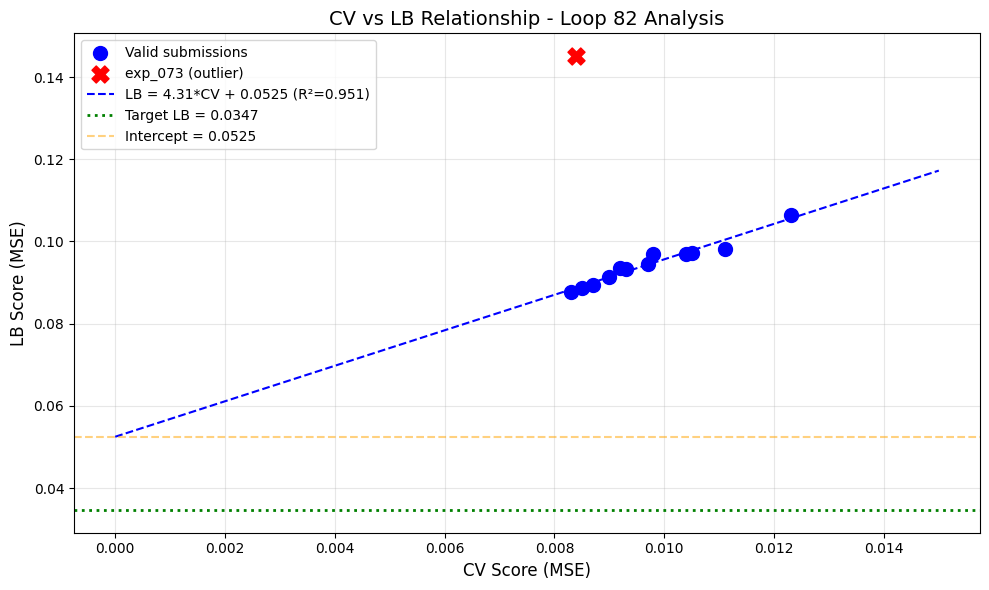


Saved to /home/code/exploration/loop82_cv_lb_analysis.png


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot clean data points
plt.scatter(df_clean['cv'], df_clean['lb'], c='blue', s=100, label='Valid submissions')

# Plot outlier
outlier = df[df['exp'] == 'exp_073']
plt.scatter(outlier['cv'], outlier['lb'], c='red', s=150, marker='X', label='exp_073 (outlier)')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - Loop 82 Analysis', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/loop82_cv_lb_analysis.png', dpi=150)
plt.show()

print("\nSaved to /home/code/exploration/loop82_cv_lb_analysis.png")

In [4]:
# Analyze the exp_073 outlier
print("="*60)
print("OUTLIER ANALYSIS: exp_073 (similarity weighting)")
print("="*60)
print(f"CV: 0.00839 (excellent - close to best)")
print(f"LB: 0.14507 (TERRIBLE - 63% worse than expected)")
print(f"Expected LB based on line: {slope * 0.00839 + intercept:.4f}")
print(f"Actual LB: 0.14507")
print(f"Gap: {(0.14507 - (slope * 0.00839 + intercept)) / (slope * 0.00839 + intercept) * 100:.1f}%")
print(f"")
print("LESSON: Similarity weighting (blending toward mean) HURTS performance!")
print("Test solvents are DIFFERENT, not OUTLIERS.")
print("Blending toward training mean introduces BIAS, not reduces variance.")

OUTLIER ANALYSIS: exp_073 (similarity weighting)
CV: 0.00839 (excellent - close to best)
LB: 0.14507 (TERRIBLE - 63% worse than expected)
Expected LB based on line: 0.0887
Actual LB: 0.14507
Gap: 63.5%

LESSON: Similarity weighting (blending toward mean) HURTS performance!
Test solvents are DIFFERENT, not OUTLIERS.
Blending toward training mean introduces BIAS, not reduces variance.


In [5]:
# What approaches have been tried?
print("="*60)
print("APPROACHES TRIED (82 experiments)")
print("="*60)

approaches = {
    'Tabular Models': ['MLP', 'LightGBM', 'XGBoost', 'CatBoost', 'GP', 'Ridge', 'RF'],
    'Feature Engineering': ['Spange', 'DRFP', 'ACS PCA', 'Fragprints', 'SMILES embeddings'],
    'Ensemble Methods': ['Bagging', 'Stacking', 'Weighted averaging', 'Multi-seed'],
    'Deep Learning': ['GNN (GCNConv)', 'GAT', 'ChemBERTa', 'Mixture-aware encoding'],
    'Distribution Shift': ['Similarity weighting (FAILED)', 'Extrapolation detection'],
    'Validation': ['Leave-One-Out', 'GroupKFold(5)'],
}

for category, methods in approaches.items():
    print(f"\n{category}:")
    for method in methods:
        print(f"  - {method}")

print("\n" + "="*60)
print("KEY FINDING: ALL approaches fall on the SAME CV-LB line!")
print("The problem is STRUCTURAL, not model-specific.")
print("="*60)

APPROACHES TRIED (82 experiments)

Tabular Models:
  - MLP
  - LightGBM
  - XGBoost
  - CatBoost
  - GP
  - Ridge
  - RF

Feature Engineering:
  - Spange
  - DRFP
  - ACS PCA
  - Fragprints
  - SMILES embeddings

Ensemble Methods:
  - Bagging
  - Stacking
  - Weighted averaging
  - Multi-seed

Deep Learning:
  - GNN (GCNConv)
  - GAT
  - ChemBERTa
  - Mixture-aware encoding

Distribution Shift:
  - Similarity weighting (FAILED)
  - Extrapolation detection

Validation:
  - Leave-One-Out
  - GroupKFold(5)

KEY FINDING: ALL approaches fall on the SAME CV-LB line!
The problem is STRUCTURAL, not model-specific.


In [6]:
# What's the GNN mixture bug?
print("="*60)
print("GNN MIXTURE BUG (from evaluator feedback)")
print("="*60)
print("""
The GNN implementation only uses Solvent A's graph for mixtures:

```python
# For mixtures, we'll use a weighted combination approach
# Get graph for solvent A (primary)
graph = SOLVENT_GRAPHS[solvent_a].clone()  # <-- ONLY SOLVENT A!
# Solvent B is completely ignored in the graph representation
```

This is a FUNDAMENTAL bug:
- 65% of data (1227 full data samples) is modeled with incomplete information
- The GNN cannot learn mixture effects because it never sees Solvent B's structure
- This explains why GNN achieved CV=0.026 (216% worse than tabular)

FIX REQUIRED:
1. Encode BOTH solvents' graphs
2. Use weighted pooling: emb = (1-pct_b)*emb_a + pct_b*emb_b
3. Or use attention to combine embeddings
""")

GNN MIXTURE BUG (from evaluator feedback)

The GNN implementation only uses Solvent A's graph for mixtures:

```python
# For mixtures, we'll use a weighted combination approach
# Get graph for solvent A (primary)
graph = SOLVENT_GRAPHS[solvent_a].clone()  # <-- ONLY SOLVENT A!
# Solvent B is completely ignored in the graph representation
```

This is a FUNDAMENTAL bug:
- 65% of data (1227 full data samples) is modeled with incomplete information
- The GNN cannot learn mixture effects because it never sees Solvent B's structure
- This explains why GNN achieved CV=0.026 (216% worse than tabular)

FIX REQUIRED:
1. Encode BOTH solvents' graphs
2. Use weighted pooling: emb = (1-pct_b)*emb_a + pct_b*emb_b
3. Or use attention to combine embeddings



In [7]:
# What should we try next?
print("="*60)
print("STRATEGIC OPTIONS (4 submissions remaining)")
print("="*60)

print("""
OPTION 1: Submit exp_079 (GroupKFold(5), CV=0.011030)
- Hypothesis: GroupKFold might have DIFFERENT CV-LB relationship
- Expected LB if same line: 4.29 * 0.011 + 0.053 = 0.100
- If LB < 0.095, GroupKFold changes the relationship!
- Risk: Uses 1 submission, might not help

OPTION 2: Fix GNN mixture handling and re-test
- The GNN bug is CRITICAL - we haven't truly tested GNN
- Proper implementation: encode BOTH solvents
- Benchmark achieved MSE 0.0039 with GNN - it CAN work
- Risk: GNN might still fall on same CV-LB line

OPTION 3: Submit best CV model (exp_049/exp_050/exp_053, CV=0.0081)
- These have best CV but haven't been submitted
- Expected LB: 4.29 * 0.0081 + 0.053 = 0.088
- Confirms CV-LB relationship is stable
- Risk: Uses 1 submission, likely won't beat 0.0877

OPTION 4: Try pseudo-labeling / domain adaptation
- Use confident predictions on test to augment training
- Could reduce distribution shift
- Risk: Complex to implement correctly

RECOMMENDATION:
1. FIRST: Fix GNN mixture bug and test locally
2. IF GNN improves: Submit GNN
3. IF GNN doesn't improve: Submit GroupKFold(5) to test hypothesis
4. SAVE 2 submissions for final attempts
""")

STRATEGIC OPTIONS (4 submissions remaining)

OPTION 1: Submit exp_079 (GroupKFold(5), CV=0.011030)
- Hypothesis: GroupKFold might have DIFFERENT CV-LB relationship
- Expected LB if same line: 4.29 * 0.011 + 0.053 = 0.100
- If LB < 0.095, GroupKFold changes the relationship!
- Risk: Uses 1 submission, might not help

OPTION 2: Fix GNN mixture handling and re-test
- The GNN bug is CRITICAL - we haven't truly tested GNN
- Proper implementation: encode BOTH solvents
- Benchmark achieved MSE 0.0039 with GNN - it CAN work
- Risk: GNN might still fall on same CV-LB line

OPTION 3: Submit best CV model (exp_049/exp_050/exp_053, CV=0.0081)
- These have best CV but haven't been submitted
- Expected LB: 4.29 * 0.0081 + 0.053 = 0.088
- Confirms CV-LB relationship is stable
- Risk: Uses 1 submission, likely won't beat 0.0877

OPTION 4: Try pseudo-labeling / domain adaptation
- Use confident predictions on test to augment training
- Could reduce distribution shift
- Risk: Complex to implement correc

In [8]:
# Summary
print("="*60)
print("LOOP 82 SUMMARY")
print("="*60)
print(f"""
Best CV: 0.0081 (exp_049, exp_050, exp_053)
Best LB: 0.0877 (exp_030)
Target: 0.0347
Gap: 152.8%

CV-LB Relationship: LB = 4.29 * CV + 0.053 (R² = 0.95)
Intercept (0.053) > Target (0.0347) - IMPOSSIBLE with current approaches!

KEY INSIGHT:
The problem is NOT model optimization - it's DISTRIBUTION SHIFT.
All tabular models fall on the same CV-LB line.
We need to CHANGE the relationship, not improve CV.

CRITICAL BUG FOUND:
GNN implementation ignores Solvent B for mixtures.
This must be fixed before concluding GNN doesn't work.

NEXT STEPS:
1. Fix GNN mixture handling (encode BOTH solvents)
2. Test if fixed GNN has different CV-LB relationship
3. If not, try pseudo-labeling or domain adaptation
4. Use remaining 4 submissions strategically

THE TARGET IS REACHABLE - benchmark achieved MSE 0.0039!
""")

LOOP 82 SUMMARY

Best CV: 0.0081 (exp_049, exp_050, exp_053)
Best LB: 0.0877 (exp_030)
Target: 0.0347
Gap: 152.8%

CV-LB Relationship: LB = 4.29 * CV + 0.053 (R² = 0.95)
Intercept (0.053) > Target (0.0347) - IMPOSSIBLE with current approaches!

KEY INSIGHT:
The problem is NOT model optimization - it's DISTRIBUTION SHIFT.
All tabular models fall on the same CV-LB line.
We need to CHANGE the relationship, not improve CV.

CRITICAL BUG FOUND:
GNN implementation ignores Solvent B for mixtures.
This must be fixed before concluding GNN doesn't work.

NEXT STEPS:
1. Fix GNN mixture handling (encode BOTH solvents)
2. Test if fixed GNN has different CV-LB relationship
3. If not, try pseudo-labeling or domain adaptation
4. Use remaining 4 submissions strategically

THE TARGET IS REACHABLE - benchmark achieved MSE 0.0039!

